In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import joblib
from tqdm import tqdm

In [11]:
CHAR_SHEET_TRAIN = ['char01(B)', 'char02(D)', 'char03(G)', 'char04(L)', 'char05(O)', 'char06(Q)',
                    'char07(S)', 'char08(V)', 'char09(Z)', 'char10(4)', 'char11(7)', 'char12(9)']
CHAR_SHEET_TEST = ['char' + str(i) for i in range(13, 23)]

In [12]:
def read_single_excel(root, prefix, file_type, sheetName):
    path = os.path.join(root, prefix, prefix + file_type + '.xlsx')
    data = pd.read_excel(path, sheet_name=sheetName, header=None)
    print(f'file path: {path}, \t sheet name: {sheetName}, \t shape: {data.shape}')
    return data
def data_exists(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return os.path.exists(path)
def load_data(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.load(path)
def save_data(root,variable_name,variable):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.dump(variable, path)

In [13]:
# 读取数据
root = './'
train_data, test_data, test_event, train_event = [], [], [], []
if data_exists(root, 'train_data'):
    train_data=load_data(root, 'train_data')
    test_data=load_data(root, 'test_data')
    test_event=load_data(root, 'test_event')
    train_event=load_data(root, 'train_event')
else:
    for i in range(1, 6):
        prefix = 'S' + str(i)
        train_data_i, test_data_i, test_event_i, train_event_i = [], [], [], []
        for sheet_name in CHAR_SHEET_TRAIN:
            train_data_i.append(read_single_excel(root, prefix, '_train_data', sheet_name))
            train_event_i.append(read_single_excel(root, prefix, '_train_event', sheet_name))
        for sheet_name in CHAR_SHEET_TEST:
            if i == 2 and sheet_name == 'char22': # 跳过 S2 数据缺失问题
                test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
                test_event_i.append(None)
                continue
            if i == 3 and sheet_name == 'char22': # 跳过 S3 数据缺失问题
                test_data_i.append(None)
                test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
                continue
            test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
            test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
        train_data.append(train_data_i)
        test_data.append(test_data_i)
        test_event.append(test_event_i)
        train_event.append(train_event_i)
    save_data(root, 'train_data', train_data)
    save_data(root, 'test_data', test_data)
    save_data(root, 'test_event', test_event)
    save_data(root, 'train_event', train_event)
print(f'{len(train_data)}, \t {len(train_event)}, \t {len(test_data)}, \t {len(test_event)}')
print(f'{len(train_data[0])}, \t {len(train_event[0])}, \t {len(test_data[0])}, \t {len(test_event[0])}')
print(type(train_data[0][0]))

5, 	 5, 	 5, 	 5
12, 	 12, 	 10, 	 10
<class 'pandas.core.frame.DataFrame'>


In [14]:
train_data[0][0].iloc[:3000,0]

0       10849.580815
1       10849.893740
2       10848.016193
3       10845.781019
4       10846.719792
            ...     
2995    10960.132537
2996    10962.010083
2997    10966.793356
2998    10967.016874
2999    10966.793356
Name: 0, Length: 3000, dtype: float64

In [15]:
train_data[0][0].shape

(3125, 20)

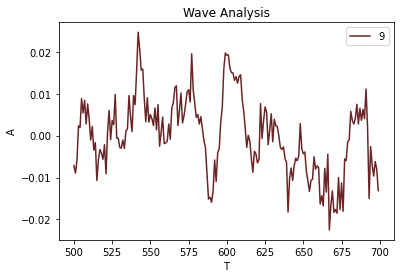

In [16]:
# 画图
time_from_to = [500,int(500+800/4)]
# 4ms一次采样，放缩fuzzy倍
fuzzy = 1
# 观察哪些通道
channels = [8]
# channels = list(range(20))|

np.random.seed(17)
colors = np.random.rand(20,3,)
plt.title('Wave Analysis')
x = list(range(time_from_to[0],time_from_to[1], fuzzy))
y = train_data[0][0].iloc[time_from_to[0]:time_from_to[1],:20]
y = y.loc[x]
for i in channels:
    thisy = y.iloc[:,i]
    # thisy /= np.var(thisy)
    thisy /= np.mean(thisy)
    thisy -= np.mean(thisy)
    plt.plot(x, thisy, color=colors[i], label=str(i+1))
plt.legend() # 显示图例

plt.xlabel('T')
plt.ylabel('A')
plt.show()

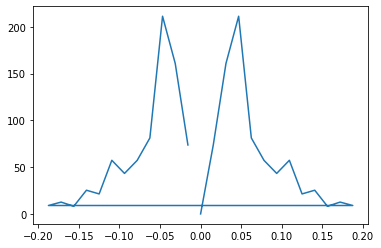

In [17]:
n = 64
sp=np.fft.fft(train_data[0][0].iloc[800:1000,0],n=n)
sp[np.abs(sp)>3000]=0
freq = np.fft.fftfreq(n)
# plt.plot(freq, sp.real, freq, sp.imag)
plt.plot(freq[np.nonzero(abs(freq)<0.2)], np.abs(sp[np.nonzero(abs(freq)<0.2)]))
plt.show()
# print(sp,freq)

In [136]:
# 特征工程
import pywt

from sklearn.decomposition import FastICA
fast_ica = FastICA(n_components=20)

n = 64

'''
A	101	B	102	C	103	D	104	E	105	F	106
G	107	H	108	I	109	J	110	K	111	L	112
M	113	N	114	O	115	P	116	Q	117	R	118
S	119	T	120	U	121	V	122	W	123	X	124
Y	125	Z	126	1	127	2	128	3	129	4	130
5	131	6	132	7	133	8	134	9	135	0	136
'''
map_char_id={
    "A":101,"B":102,"C":103,"D":104,"E":105,"F":106,
    "G":107,"H":108,"I":109,"J":110,"K":111,"L":112,
    "M":113,"N":114,"O":115,"P":116,"Q":117,"R":118,
    "S":119,"T":120,"U":121,"V":122,"W":123,"X":124,
    "Y":125,"Z":126,"1":127,"2":128,"3":129,"4":130,
    "5":131,"6":132,"7":133,"8":134,"9":135,"0":136,
}
map_id_char={}
for char,id in map_char_id.items():
    map_id_char[id]=char
exists_xy_char=["","ABCDEF","GHIJKL","MNOPQR","STUVWX","YZ1234","567890","AGMSY5","BHNTZ6","CIOU17","DJPV28","EKQW39","FLRX40"]
for i,v in enumerate(exists_xy_char):
    m = set()
    for c in v:
        m.add(c)
    exists_xy_char[i]=m


def WPEnergy(data, fs, wavelet, maxlevel=6):
    iter_freqs = [
        {'name': 'Delta', 'fmin': 0.5, 'fmax': 4},
        {'name': 'Theta', 'fmin': 4, 'fmax': 8},
        {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
        {'name': 'Beta', 'fmin': 13, 'fmax': 35},
    ]
    # 小波包分解
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    # 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    # 计算maxlevel最小频段的带宽
    freqBand = fs / (2 ** maxlevel)
    # 定义能量数组
    energy = []
    # 循环遍历计算四个频段对应的能量
    for iter in range(len(iter_freqs)):
        iterEnergy = 0.0
        for i in range(len(freqTree)):
            # 第i个频段的最小频率
            bandMin = i * freqBand
            # 第i个频段的最大频率
            bandMax = bandMin + freqBand
            # 判断第i个频段是否在要分析的范围内
            if (iter_freqs[iter]['fmin'] <= bandMin and iter_freqs[iter]['fmax'] >= bandMax):
                val = pow(np.linalg.norm(wp[freqTree[i]].data, ord=None), 2)
                if val<100000:
                    # 计算对应频段的累加和
                    iterEnergy += val
        # 保存四个频段对应的能量和
        energy.append(iterEnergy)
    # 绘制能量分布图
    # plt.plot([xLabel['name'] for xLabel in iter_freqs], energy, lw=0, marker='o')
    # plt.title('能量分布')
    # plt.show()
    return energy

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

def maxpool(data,n,step):
    data2 = []
    for i in range(n//2,len(data)-(-n//2+n),step):
        data2.append(max(data[i-n//2:i-n//2+n]))
    return data2

def get_data():
    features = []
    tags = []
    # FIXME:
    # for i_person in range(5):
    for i_person in range(1):
        for i_char_sheet in tqdm(range(len(CHAR_SHEET_TRAIN))):
            char_id=train_event[i_person][i_char_sheet].iloc[0,0]
            char=map_id_char[char_id]
            begin_time=train_event[i_person][i_char_sheet].iloc[0,1]
            data = np.array(train_data[i_person][i_char_sheet])
            # print(data[0,3]==train_data[i_person][i_char_sheet].iloc[0,3])
            # data -= np.mean(data,axis=1,keepdims=True)
            # data2 = fast_ica.fit_transform(data)
            for i_row in range(1,len(train_event[i_person][i_char_sheet]),13):
                data_group = train_event[i_person][i_char_sheet].iloc[i_row:i_row+12]
                # print(data_group,i_row)
                for i in range(12):
                    sp = []
                    sp1 = []
                    # sp1 = np.concatenate([WPEnergy(data[int(data_group.iloc[i,1]) : int(data_group.iloc[i,1])+100,j],fs=125, wavelet='db4', maxlevel=6) for j in range(20)])
                    for j in range(20):
                        paras=[0,60,120]
                        chan = []
                        for p in range(len(paras)-1):
                            t = WPEnergy(standardization(data[int(data_group.iloc[i,1])+paras[p] : int(data_group.iloc[i,1])+paras[p+1],j]),fs=125, wavelet='db4', maxlevel=6)
                            chan.append(t)
                        # chan.append(np.sum(np.asarray([normalization(c) for c in chan[:len(paras)-1]]),axis=0))
                        chan.append(np.sum(np.asarray(chan[:len(paras)-1]),axis=0))
                        chan = [normalization(c) for c in chan]
                        sp1.append(chan)
                    sp1 = np.mean(np.array(sp1),axis=0)
                    sp1 = np.concatenate(sp1)
                    # sp1 = np.concatenate([Data[j][int(data_group.iloc[i,1]/trans_coef):int((data_group.iloc[i,1]+100)/trans_coef)] for j in range(20)])
                    sp2 = []
                    sp3 = []
                    fourier = []
                    for j in range(20):
                        d = standardization(data[int(data_group.iloc[i,1]): int(data_group.iloc[i,1])+120,j])
                        # 三次haar小波变换，相当于低通滤波，降噪
                        d, _ = pywt.dwt(d, 'haar')
                        d, _ = pywt.dwt(d, 'haar')
                        d, _ = pywt.dwt(d, 'haar')
                        # d = maxpool(d,3,1)
                        sp2.append(d)
                        # sp3.append(np.abs(np.fft.fft(d,n=n)))
                    # sp2 = np.concatenate(sp2)
                    sp2 = np.mean(sp2,axis=0)
                    # sp3 = np.concatenate(sp3)
                    fourier=np.concatenate([np.abs(np.fft.fft(
                            data[int(data_group.iloc[i,1]):int(data_group.iloc[i,1])+120,j],n=n
                        )) for j in range(20)])
                    fourier[np.abs(fourier)>5000]=0
                    # fourier[fourier<-5000]=-5000
                    # fourier[fourier>5000]=5000
                    fourier=fourier[np.nonzero(abs(freq)<0.2)]
                    sp = np.concatenate([sp, fourier, sp1, sp2])
                    features.append(sp)
                    tags.append(int(char in exists_xy_char[int(data_group.iloc[i,0])]))
                # return
    return np.asarray(features),np.asarray(tags)
features, tags = get_data()
# res = WPEnergy2(train_data[0][0].iloc[100:200,0],fs=125, wavelet='db4', maxlevel=8)
# train_data,res
# np.asarray(pywt.dwt(train_data[0][0].iloc[100:200,0], 'haar')).shape



100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


In [138]:
# tags
features.shape

(720, 52)

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
x_train,x_test,y_train,y_test = train_test_split(features,        # 特征空间
                                                    tags,      # 输出空间
                                                    test_size = 3/12,    # 测试集占k/12个sheet
                                                    random_state = 47,  # 为了复现实验，设置一个随机数
                                                    shuffle=False
                                                    )

def svc_cv(C, gamma, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    # cval = cross_val_score(estimator, data, targets, scoring='recall', cv=4)
    return cval.mean()

def optimize_svc(data, targets, n_iter=10):
    """Apply Bayesian Optimization to SVC parameters."""

    def svc_crossval(expC, expGamma):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (2, 3), "expGamma": (2, 3)},
        random_state=3333,
        verbose=2
    )
    optimizer.maximize(n_iter=n_iter)

    print("Final result:", optimizer.max)


def xgboost_cv(data,targets,max_depth,learning_rate,n_estimators,min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = XGBClassifier(
        max_depth=max_depth, 
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        max_delta_step=max_delta_step,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        nthread=5,
        # eval_metric='error@'+str(errorat),
        # eval_metric='auc',
        # eval_metric='recall',
        # eval_metric=["auc","rmse","logloss"],
        scale_pos_weight=6,
        objective='reg:logistic',
    )
    # cval = cross_val_score(estimator, data, targets, scoring='recall', cv=5)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=5)
    return cval.mean()

def optimize_xgboost(data, targets, n_iter=10):
    """Apply Bayesian Optimization to SVC parameters."""

    def xgboost_crossval(max_depth,learning_rate,n_estimators,min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda):
        return xgboost_cv(data, targets,int(max_depth),learning_rate,int(n_estimators),min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda)

    optimizer = BayesianOptimization(
        f=xgboost_crossval,
        pbounds={
            'max_depth': [3, 25],
            'learning_rate': [0.01, 0.15],
            'n_estimators': [10, 80],
            'min_child_weight': [15, 50],
            'max_delta_step': [2, 5],
            'subsample': [0.6, 0.95],
            'colsample_bytree': [0.5, 0.9],
            'reg_alpha': [0, 1],
            'reg_lambda': [0.2, 1]
        },
        random_state=3333,
        verbose=2
    )
    optimizer.maximize(n_iter=n_iter)

    print("Final result:", optimizer.max)

%time optimize_xgboost(x_train,y_train,45)

# optimize_svc(features,tags,45)

|   iter    |  target   | colsam... | learni... | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6849   |  0.8006   |  0.0253   |  3.458    |  14.0     |  38.0     |  26.51    |  0.6128   |  0.2957   |  0.8493   |
|  2        |  0.6689   |  0.649    |  0.08347  |  2.79     |  16.68    |  30.72    |  25.33    |  0.8482   |  0.9527   |  0.9477   |
|  3        |  0.6935   |  0.5614   |  0.09532  |  2.872    |  9.401    |  43.64    |  52.68    |  0.6112   |  0.8891   |  0.7299   |
|  4        |  0.6817   |  0.5775   |  0.07489  |  2.662    |  5.645    |  38.33    |  60.86    |  0.4588   |  0.494    |  0.7048   |
|  5        |  0.6516   |  0.6024   |  0.1109   |  2.059    |  20.33    |  17.21    |  24.33    |  0.4771   |  0.3006   |  0.7918   |
|  6        |  0.7019   |  0.8567   |  0.07749  |  4.778    | 

In [181]:
# 检验数据是否被打乱
np.sum((features[:len(x_train)]==x_train)==True)==x_train.shape[0]*x_train.shape[1]

True

In [140]:
from xgboost import XGBClassifier
def train_svm(params):
    # logspace(a,b,N)把10的a次方到10的b次方区间分成N份
    # gamma_range = np.logspace(-9, 3, 10)
    # param_grid = dict(gamma=gamma_range, C=C_range)
    # cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    # p = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    C = 10 ** params['expC']
    gamma = 10 ** params['expGamma']
    p=SVC(C=C, gamma=gamma, random_state=2)
    p.fit(x_train, y_train)
    return p

def train_xgboost(params):
    model = XGBClassifier(
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        max_delta_step=params['max_delta_step'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        n_estimators=int(params['n_estimators']),
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        subsample=params['subsample'],
        eval_metric=["auc","rmse","logloss"],
        scale_pos_weight=6,
        objective='reg:logistic',
    )
    model.fit(x_train,y_train)
    return model    

def train_xgboost2():
    model = XGBClassifier(learning_rate=learning_rate, n_estimators=num_round, max_depth=max_depth,
                    min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda, colsample_bytree=colsample_bytree, objective='binary:logistic',
                    nthread=4, scale_pos_weight=scale_pos_weight, seed=seed)
    model.fit(x_train,y_train)
    return model

# %time model = train_svm({'expC': 2.323420033309046, 'expGamma': 1.570225873685972})
# %time model = train_xgboost({'colsample_bytree': 0.6777296845518767, 'errorat': 0.4145593781640215, 'learning_rate': 0.02410815068218079, 'max_delta_step': 0.025245950057545707, 'max_depth': 6.086558645510136, 'min_child_weight': 19.58672950443147, 'n_estimators': 232.7855648541887, 'reg_alpha': 0.6165691427262426, 'reg_lambda': 0.8524583027711861, 'subsample': 0.8684270346032827})
# %time model = train_xgboost({'colsample_bytree': 0.9, 'errorat': 0.2, 'learning_rate': 0.005, 'max_delta_step': 2.0, 'max_depth': 2.0, 'min_child_weight': 20.0, 'n_estimators': 60.73754308716246, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.95})
%time model = train_xgboost({'colsample_bytree': 0.5615520102976814, 'learning_rate': 0.0908458208199835, 'max_delta_step': 3.337772575935354, 'max_depth': 13.974611084182738, 'min_child_weight': 38.0182839179346, 'n_estimators': 26.13271506820752, 'reg_alpha': 0.530499894562367, 'reg_lambda': 0.47106899139747455, 'subsample': 0.6193068193591333})

# %time model = train_xgboost2()

CPU times: user 55.2 ms, sys: 0 ns, total: 55.2 ms
Wall time: 15.9 ms


In [141]:
# 评估模型

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

y_pred=model.predict(x_test)

print(y_test[:50])
print(y_pred[:50])

# for sheet_base in range(0,len(y_pred),12*5):
#     for batch_base in range(sheet_base,sheet_base+12*5,12):
#         i_sheet = sheet_base//(12*5)
#         i_event = 1 + (batch_base - sheet_base)//12
#         d = y_pred[batch_base:batch_base+12]
        
    

# print(y_pred)

# 准确率
precision = accuracy_score(y_test, y_pred)
# 召回率
recall = recall_score(y_test, y_pred)

precision, recall

[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0
 1 0 0 1 1 0 0 0 1 1 0 0 1]


(0.6277777777777778, 0.6666666666666666)

array([1, 1, 0, ..., 0, 0, 0])